<a href="https://colab.research.google.com/github/Ashutosh-Gairola/DL/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load Caltech-101 dataset
dataset_name = "caltech101"
(train_ds, test_ds), ds_info = tfds.load(
    dataset_name,
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,  # returns (image, label) tuple
    with_info=True,
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incomplete9EI28R/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incomplete9EI28R/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


In [3]:
# Print number of categories
num_categories = ds_info.features["label"].num_classes
print("Number of categories:", num_categories)

Number of categories: 102


In [4]:
# Print names of the classes
class_names = ds_info.features["label"].names
print("Class names:")
for idx, class_name in enumerate(class_names):
    print(f"{idx + 1}: {class_name}")

Class names:
1: accordion
2: airplanes
3: anchor
4: ant
5: background_google
6: barrel
7: bass
8: beaver
9: binocular
10: bonsai
11: brain
12: brontosaurus
13: buddha
14: butterfly
15: camera
16: cannon
17: car_side
18: ceiling_fan
19: cellphone
20: chair
21: chandelier
22: cougar_body
23: cougar_face
24: crab
25: crayfish
26: crocodile
27: crocodile_head
28: cup
29: dalmatian
30: dollar_bill
31: dolphin
32: dragonfly
33: electric_guitar
34: elephant
35: emu
36: euphonium
37: ewer
38: faces
39: faces_easy
40: ferry
41: flamingo
42: flamingo_head
43: garfield
44: gerenuk
45: gramophone
46: grand_piano
47: hawksbill
48: headphone
49: hedgehog
50: helicopter
51: ibis
52: inline_skate
53: joshua_tree
54: kangaroo
55: ketch
56: lamp
57: laptop
58: leopards
59: llama
60: lobster
61: lotus
62: mandolin
63: mayfly
64: menorah
65: metronome
66: minaret
67: motorbikes
68: nautilus
69: octopus
70: okapi
71: pagoda
72: panda
73: pigeon
74: pizza
75: platypus
76: pyramid
77: revolver
78: rhino
79: 

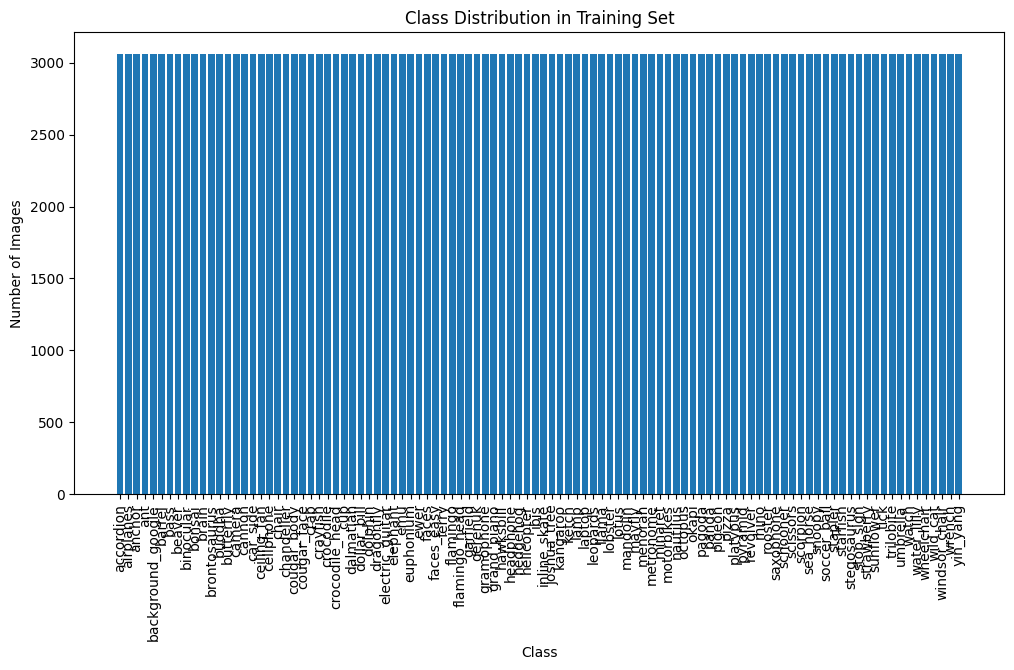

In [5]:


# Count the number of images in each class
class_counts = train_ds.reduce(initial_state=tf.zeros(num_categories, dtype=tf.int64),
                               reduce_func=lambda count, _: count + 1)

# Plot the class distribution
plt.figure(figsize=(12, 6))
plt.bar(range(num_categories), class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Training Set')
plt.xticks(range(num_categories), class_names, rotation=90)
plt.show()


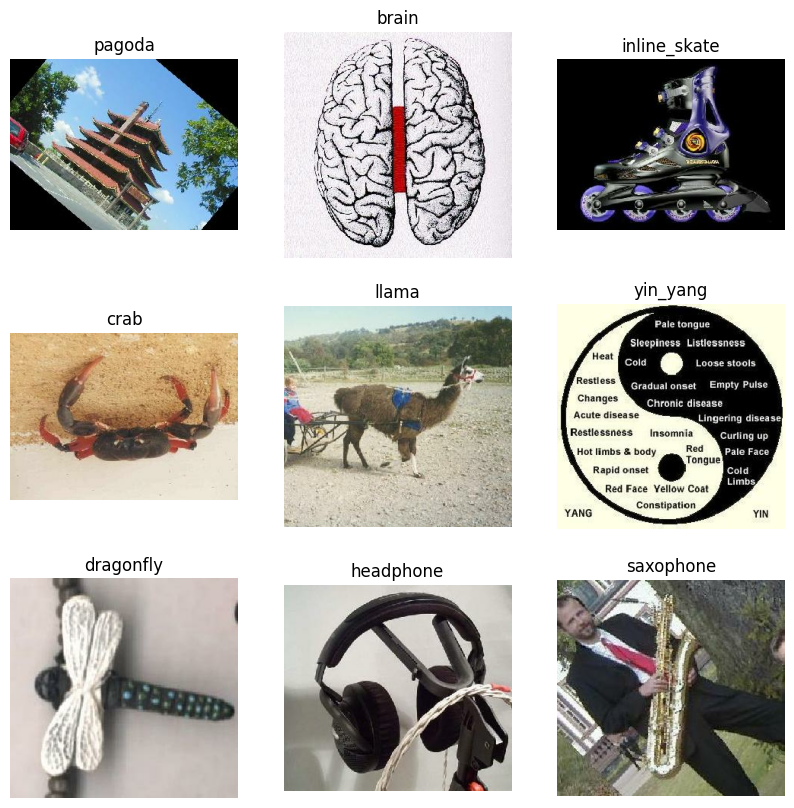

In [6]:

# Display a few sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label.numpy()])
    plt.axis("off")
plt.show()


In [7]:
# Define the CNN model with regularization and dropout
def create_model(input_shape, num_classes, dropout_rate=0.05, l2_reg=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu',
                      kernel_regularizer=tf.keras.regularizers.l2(l2_reg)),
        layers.Flatten(),
        layers.Dropout(dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

In [8]:
# Define the learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)

In [9]:
# Reshape the input images
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Adjust the image dimensions as needed

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, (IMG_HEIGHT, IMG_WIDTH)), y))

# Ensure images have the correct shape
train_ds = train_ds.map(lambda x, y: (tf.reshape(x, (-1, IMG_HEIGHT, IMG_WIDTH, 3)), tf.reshape(y, (-1,))))
test_ds = test_ds.map(lambda x, y: (tf.reshape(x, (-1, IMG_HEIGHT, IMG_WIDTH, 3)), tf.reshape(y, (-1,))))

# Create the model
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)  # 3 channels for RGB images
num_classes = len(class_names)
model = create_model(input_shape, num_classes)

# Compile the model
initial_learning_rate = 0.1
opt = Adam(lr=initial_learning_rate)
model.compile(optimizer=opt,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define callbacks
callbacks_list = [
    callbacks.ModelCheckpoint(filepath='caltech101_model.h5',  # Save the model after each epoch
                               monitor='val_accuracy',
                               verbose=1,
                               save_best_only=True),
    LearningRateScheduler(lr_scheduler)
]

# Train the model
history = model.fit(train_ds,
                    validation_data=test_ds,
                    epochs=10,
                    callbacks=callbacks_list)

Epoch 1/10
3060/3060 [==============================] - ETA: 0s - loss: 5.2753 - accuracy: 0.0232
Epoch 1: val_accuracy improved from -inf to 0.02334, saving model to caltech101_model.h5
3060/3060 [==============================] - 284s 92ms/step - loss: 5.2753 - accuracy: 0.0232 - val_loss: 4.6240 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 2/10
   1/3060 [..............................] - ETA: 2:48 - loss: 1.4301 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3060/3060 [==============================] - ETA: 0s - loss: 4.5323 - accuracy: 0.0346
Epoch 2: val_accuracy did not improve from 0.02334
3060/3060 [==============================] - 259s 85ms/step - loss: 4.5323 - accuracy: 0.0346 - val_loss: 4.6219 - val_accuracy: 0.0215 - lr: 0.0010
Epoch 3/10
3060/3060 [==============================] - ETA: 0s - loss: 4.4295 - accuracy: 0.0526
Epoch 3: val_accuracy did not improve from 0.02334
3060/3060 [==============================] - 235s 77ms/step - loss: 4.4295 - accuracy: 0.0526 - val_loss: 4.5681 - val_accuracy: 0.0182 - lr: 0.0010
Epoch 4/10
3059/3060 [============================>.] - ETA: 0s - loss: 4.4138 - accuracy: 0.0742
Epoch 4: val_accuracy did not improve from 0.02334
3060/3060 [==============================] - 259s 85ms/step - loss: 4.4138 - accuracy: 0.0742 - val_loss: 4.6676 - val_accuracy: 0.0217 - lr: 0.0010
Epoch 5/10
3060/3060 [==============================] - ETA: 0s - loss: 4.2819 - accuracy: 0.0967
Epoch 5: val_accura

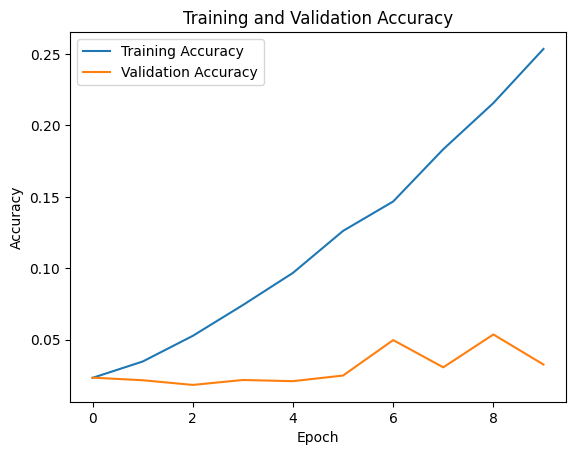

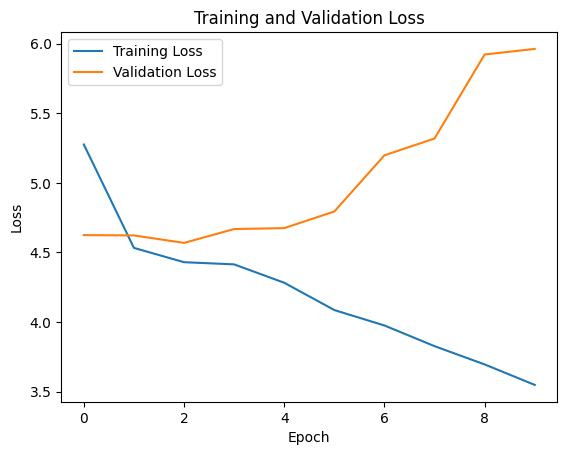

In [10]:


# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [11]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np

# Load the trained model
model = load_model('caltech101_model.h5')

# Load and preprocess the image
image_path = '/content/sample_data/areo.jpeg'
img = cv2.imread(image_path)
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))  # Resize the image to match the input size of the model
img = img / 255.0  # Normalize the pixel values to the range [0, 1]

# Reshape the image to match the model's input shape
img = np.reshape(img, (1, IMG_HEIGHT, IMG_WIDTH, 3))

# Make predictions
predictions = model.predict(img)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Print the predicted class label
print("Predicted class:", class_names[predicted_class])


1/1 [==============================] - 0s 223ms/step
Predicted class: saxophone
